# Lesson: Unsupervised Learning

## Lecture #3: Clustering
Clustering is the grouping of data such that points within clusters are more similar to each other than they are to points from other clusters. There are many types of clustering algorithms, but for the most part, they can be broken down into the following categories: 
- Centroid-based
- Distribution-based
- Density-based
- Hierarchical
- Graph-based

In the slides which accompany this notebook, we walked you through the theory behind these methods. **Here, we'll show you how to actually implement these algorithms using Python & (mostly) [scikit-learn](https://scikit-learn.org/stable/index.html). In particular, we can lean on the [cluster package](https://scikit-learn.org/stable/modules/clustering.html#clustering) within.**

Let's start by importing & examining a new dataset which, for now, all you know is that it's related to some sort of fluid dynamics experiment...

### Exploratory Data Analysis (EDA)

In [1]:
### import some standard data science packages
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### import scikit-learn... the leading ML package out there
import sklearn as skl
import sklearn.cluster as sklc
import sklearn.metrics as sklm

### import time... purely for demonstration purposes later
import time

### let's pull our data (& for the sake of mystery, let's not import the column names)
df = pd.read_csv('Data/data_clustering.csv', header=None, skiprows=[0])
print(df.head())

          0         1     2            3
0  0.008485  0.103018   5.0  1751.341186
1  0.005960  0.126090   5.0  1733.537738
2  0.002525  0.152121   5.0  1738.440493
3  0.002525  0.152660  30.0  3386.088586
4  0.000808  0.150804   5.0  1756.014714


Since we don't really know what the data are that we're working w/, we should start as any good data scientist would, by learning a bit about it. After of course just visually inspecting the data, **the best way to do that is to visualize it!**

One of the best plots you can make when first examining data is what is called a [pair grid in seaborn](https://seaborn.pydata.org/generated/seaborn.PairGrid.html). In short, this function plots the values for each pairwise combination of variables you have. Normally, [seaborn](https://seaborn.pydata.org/) assumes your data is in long-form by default. However, the pairwise plot is a rare exception to that rule. 

Oh, & in case you are new to seaborn, it is built on top of [matplotlib](https://matplotlib.org/).

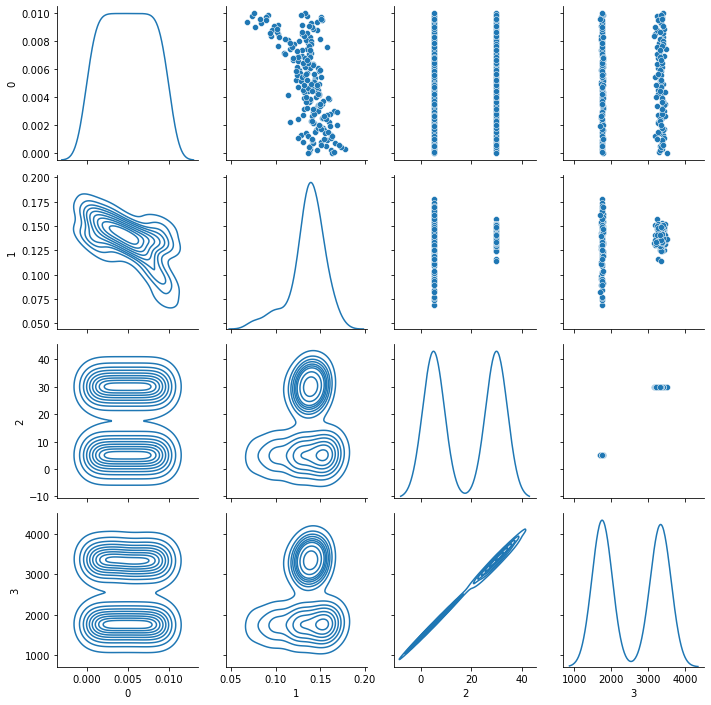

In [2]:
### create new long-form frame 
# df_plot = df.melt(var_name='Variables', value_name='Values', ignore_index=False)
# print(df_plot.head())

### let's make a pairgrid to look for patterns
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot)
# sns.pairplot(df) # you could instead do a pairplot, which is much simpler to generate but isn't quite as pretty...
plt.show()

What do you see? I'll tell you what I see... 
- Columns 0 & 1 are the most interesting in that they show the most variance. 
- Column 2 is binary in this experiment.
- Column 3 is nearly binary, though not as precisely as column 2. 

Let's do a little more [exploratory data analysis (EDA)](https://www.ibm.com/cloud/learn/exploratory-data-analysis) before we start our clustering...

In [3]:
### let's confirm our suspicions
print(df.describe())
print(df[2].unique()) # column 2 is definitely binary

                0           1           2            3
count  200.000000  200.000000  200.000000   200.000000
mean     0.005000    0.136132   17.500000  2547.199079
std      0.002923    0.019545   12.531368   795.933019
min      0.000000    0.068321    5.000000  1698.750602
25%      0.002500    0.129767    5.000000  1755.393777
50%      0.005000    0.138510   17.500000  2474.101565
75%      0.007500    0.148332   30.000000  3342.162663
max      0.010000    0.178056   30.000000  3522.587669
[ 5. 30.]


### K-Means Clustering... _ab initio_

For educational purposes, let's write a k-means algorithm from scratch. In general, of course, this won't be necessary for a data science practitioner -- this is normally reserved for the computer scientists & theoretical data scientists. But writing code to implement an algorithm is one really good way of making sure you know how that algorithm works. 


Training took 0.134 seconds


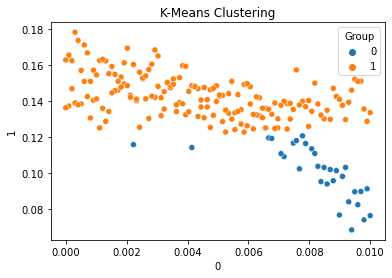

In [4]:
### create numpy 2D array w/ PC data... quicker than pandas objects
X_data = np.array([df[0], df[1]]).T

### let's create a function! (would be more functional as a class object, but don't worry about that for now)
def KM(K, X, n_iter):

### get number of examples
    m = X.shape[0]

### get number of features
    n = X.shape[1] 

### set number of clusters
    K = K
    range_k = np.arange(0, K, 1)

### start time
    time_start0 = time.time()

### initialize centroids array 
    centroids = np.empty([n,0])

### pick random points for initial centroids
    for i in range_k:
        rand = np.random.randint(0, m-1) 
        centroids = np.column_stack((centroids, X[rand]))

### initialize output dictionary (groups) <-- {cluster:[assigned data]}
    groups={}

### begin iterative process 
    for i in range(n_iter):

### initialize array for storing distances (ed)
        ed = np.empty([m,0])

### find distance from each point to each centroid
        for k in range_k:
            dist = np.sum((X - centroids[:,k])**2, axis=1)
            ed = np.column_stack((ed, dist))
            
### assign group label according to minimum ed
        label = np.argmin(ed, axis=1) 

### initialize dictionary for storing iterative labels (Y)
        Y = {}

### for each centroid, initialize a row for holding distances
        for k in range_k:
            Y[k] = np.empty([2,0])

### stack new distances onto old distances assigned to same centroid  
        for i in range(m):
            Y[label[i]] = np.column_stack((Y[label[i]],X[i]))

### transpose dictionary value arrays (such that rows contain (x,y) points)
        for k in range_k:
            Y[k] = Y[k].T

### calculate centroid means & assign as new centroids
        for k in range_k:
            centroids[:,k] = np.mean(Y[k], axis=0)

### assign last Y iteration to groups variable
    groups = Y
    
### print amount of time for training
    print("\nTraining took {:0.3f} seconds".format(time.time() - time_start0))
    
### convert to frame for simpler plotting
    df_plot = pd.DataFrame()
    for k in groups.keys():
        group = np.hstack((groups[k], [[str(k)]]*len(groups[k]))) 
        df_plot = df_plot.append(pd.DataFrame(group))
    df_plot = df_plot.rename(columns={df_plot.columns[-1]:'Cluster'})
    df_plot[df_plot.columns[0]] = df_plot[df_plot.columns[0]].astype(float)
    df_plot[df_plot.columns[1]] = df_plot[df_plot.columns[1]].astype(float)
        
### plot
    sns.scatterplot(data=df_plot, x=df_plot.columns[0], y=df_plot.columns[1], hue='Cluster')
    plt.title('K-Means Clustering')
    plt.show() 
    
    return(df_plot)
###################################################################################################################

### call function
groups = KM(K=2, X=X_data, n_iter=100)
# print("Class 0:\n{}. . .\n".format(groups[0][:5]))
# print("Class 1:\n{}. . .".format(groups[1][:5]))

Notice that in the above instance we didn't include convergence criteria. . . Our model simply iterates a specified number (`n_iter`) of times & stops. So although we've created a k-means, this is really the most basic model out there. 

### [K-Means via scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

Luckily there are brilliant people out there who enjoy writing the code for more sophisticated models which we can leverage. For k-means (& for most other shallow machine learning algorithms), scikit-learn is where that code lives. Let's see how we can build such a model using this package. 


Training took 0.022 seconds



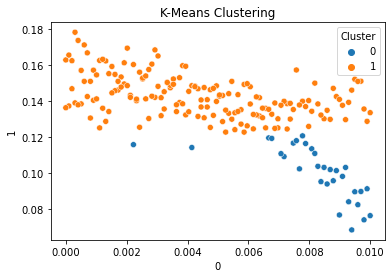

In [15]:
### start time
time_start = time.time()

### set random state
random_state = 20220313

### instantiate our k-means model
km = sklc.KMeans(n_clusters=2, n_init=10, random_state=random_state)
# groups = km.fit_predict(X_data) # used to not be compatible w/ pandas
df['Cluster'] = km.fit_predict(df[[0,1]])

### clock training time
print("\nTraining took {:0.3f} seconds\n".format(time.time() - time_start))

### plot
sns.scatterplot(data=df, x=0, y=1, hue='Cluster')
plt.title('K-Means Clustering')
plt.show() 

So how did our model compare to the scikit-learn model? In short:
- They generated the exact same clusters, so that's good. 
- Our model was slower. While the fraction of a second may not seem a big deal in this situation, it can really matter if, for example, we had a million data points w/ hundreds of columns. 
- The scikit-learn model sure was easier to actually implement. 

Luckily for us, most models contained w/i scikit-learn use the same syntax. In general, the typical workflow is as follows:
1. `model = skl.<algorithm>(hyperparameters)`
2. `results = model.fit_predict(data)`

### Optimizing Our Model
Okay, so we think we're supposed to have two clusters based on some early EDA we did (i.e. we have a hunch) -- but how do we know this is optimal? The answer, of course: **We can't.** But that doesn't mean we can just call it done. 

**Enter the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) (don't do this) & the [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)).**